# Multi-period OPF example

Re-create PyPower case from CSV files

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from nygrid.nygrid import NYGrid
from nygrid.run_nygrid import read_grid_data, read_vre_data, read_electrification_data, run_nygrid_one_day
from nygrid.plots import plot_gen

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

solar_data_dir = os.path.join(data_dir, 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

buildings_data_dir = os.path.join(data_dir, 'buildings')
print('Buildings data directory: {}'.format(buildings_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results
Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/solar
Onshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/onshore_wind
Offshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/offshore_wind
Buildings data directory: /mnt/Bo_HDD/NYgrid-python/data/buildings


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'),
                           parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'),
                          parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'),
                             parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'),
                                parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'),
                               parse_dates=['TimeStamp'], index_col='TimeStamp').asfreq('H')

In [4]:
# Remove 'Bus' prefix in column names
load_profile.columns = load_profile.columns.str.replace('Bus', '').astype(int)

In [4]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read variable renewable energy (VRE) data

In [5]:
vre_prop, genmax_profile_vre = read_vre_data(
    solar_data_dir, onshore_wind_data_dir, offshore_wind_data_dir)

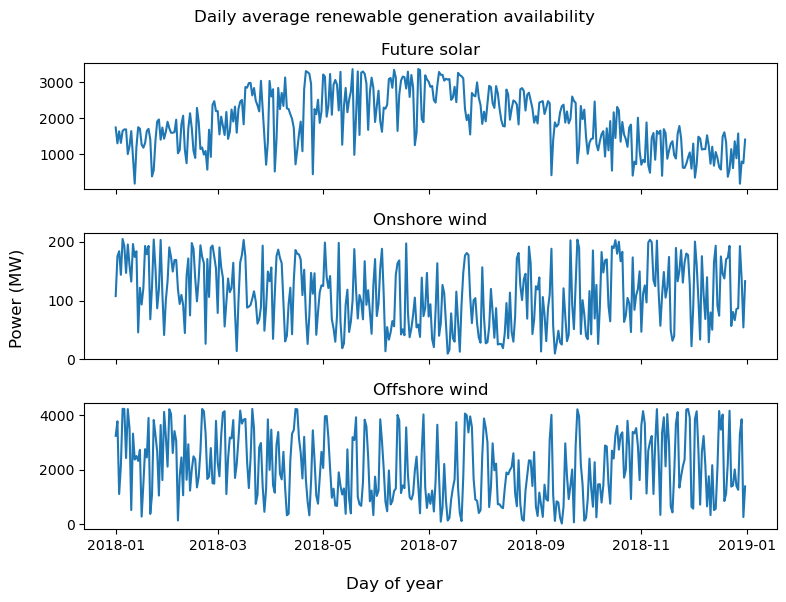

In [6]:
# Aggregate renewable generation
genmax_profile_future_solar = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('FutSol')]
genmax_sum_future_solar = genmax_profile_future_solar.sum(axis=1)
genmax_profile_onshore_wind = genmax_profile_vre.loc[:,
                                                     genmax_profile_vre.columns.str.contains('OnWind')]
genmax_sum_onshore_wind = genmax_profile_onshore_wind.sum(axis=1)
genmax_profile_offshore_wind = genmax_profile_vre.loc[:,
                                                      genmax_profile_vre.columns.str.contains('OffWind')]
genmax_sum_offshore_wind = genmax_profile_offshore_wind.sum(axis=1)

# Plot generation renewable availability
fig, axs = plt.subplots(3, 1, figsize=(8, 6),
                        sharex='all')
axs[0].plot(genmax_sum_future_solar.resample('D').mean(), label='Future solar')
axs[1].plot(genmax_sum_onshore_wind.resample('D').mean(), label='Onshore wind')
axs[2].plot(genmax_sum_offshore_wind.resample(
    'D').mean(), label='Offshore wind')

titles = ['Future solar', 'Onshore wind', 'Offshore wind']

for i, ax in enumerate(axs):
    ax.set_title(titles[i])

fig.supxlabel('Day of year')
fig.supylabel('Power (MW)')
fig.suptitle('Daily average renewable generation availability')
fig.tight_layout()

### Update load profile for electrification

In [7]:
resstock_proc_dir = "/media/by276/Bo_SSD/electrification/Data_ny/resstock_amy2018"
load_change_bus = read_electrification_data(resstock_proc_dir)



Residential load data is not available for county G3600030 Single-Family Attached. Skipping...
Residential load data is not available for county G3600170 Single-Family Attached. Skipping...
Residential load data is not available for county G3600230 Single-Family Attached. Skipping...
Residential load data is not available for county G3600490 Single-Family Attached. Skipping...
Residential load data is not available for county G3600510 Single-Family Attached. Skipping...
Residential load data is not available for county G3600950 Single-Family Attached. Skipping...
Residential load data is not available for county G3600970 Multi-Family with 5+ Units. Skipping...


In [8]:
load_profile

,21,29,35,37,38,39,40,41,42,43,...,81,82,100,102,103,124,125,132,134,138
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,181.128862,7520.013710,2576.745934,-1.517897e-12,5.575723e-13,256.94,-7.995826e-13,1284.503991,324.796009,-3.552714e-13,...,3036.65,3036.65,844.705183,-265.529207,10824.638112,2558.768404,1220.420937,12534.121972,-776.054220,260.313611
2018-01-01 01:00:00,166.202261,7318.010517,2484.808455,-7.016610e-13,2.725283e-13,245.62,-7.271961e-13,1246.989738,315.310262,6.368239e-13,...,2952.85,2952.85,816.224612,-269.100578,10513.986886,2475.654295,1183.230375,12170.965867,-759.269136,252.246599
2018-01-01 02:00:00,170.111124,7119.106496,2436.088855,-9.610091e-13,1.284413e-12,238.40,-3.332890e-13,1229.908780,310.991220,-1.088019e-12,...,2872.35,2872.35,798.740083,-255.375301,10247.332833,2426.936698,1155.200826,11844.653048,-725.257697,246.694727
2018-01-01 03:00:00,162.375198,7022.811219,2391.071799,2.238210e-13,-3.841172e-13,238.14,-7.889245e-13,1221.049031,308.750969,-5.480061e-13,...,2812.85,2812.85,785.414040,-260.277789,10100.185117,2388.939163,1137.570624,11666.822367,-716.973469,242.775129
2018-01-01 04:00:00,156.740105,6988.245199,2368.126714,-1.318945e-12,1.026218e-12,238.04,-1.909584e-13,1220.330673,308.569327,6.874501e-13,...,2786.00,2786.00,776.848401,-274.982820,10053.392029,2401.533252,1132.005794,11515.752855,-670.134754,242.918158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,170.713214,7311.843664,2491.585743,-1.270095e-12,1.492993e-12,244.00,-4.949374e-13,1150.490308,290.909692,1.435296e-12,...,2993.65,2993.65,843.979220,-159.770162,10382.584290,2586.571468,1191.574878,11896.619871,-602.858670,258.792254
2018-12-31 20:00:00,165.531661,7041.442023,2401.385609,-2.120970e-12,5.024164e-13,232.18,-4.651834e-13,1104.914481,279.385519,2.330580e-12,...,2890.85,2890.85,808.755546,-177.269719,10029.453238,2499.321734,1148.125541,11436.738771,-565.671062,249.959611
2018-12-31 21:00:00,190.928616,6659.842283,2347.982872,-2.726708e-12,7.566834e-13,221.32,-2.959855e-13,1054.709236,266.690764,-1.811884e-13,...,2784.35,2784.35,763.751247,-220.727106,9663.437798,2379.355074,1098.111911,10980.864552,-558.100652,238.661846


In [9]:
load_change_bus

,38,39,40,41,42,43,44,45,46,47,...,72,73,74,75,77,78,79,80,81,82
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,197.752999,373.203794,53.576087,1396.638800,245.805351,92.127703,88.960145,467.152080,43.461064,514.014116,...,40.050407,287.007332,410.688096,209.031703,391.709867,410.688096,1151.814322,1367.798091,1477.595062,1865.340034
2018-01-01 01:00:00,221.997819,447.035593,51.958410,1407.913873,245.129079,121.925798,121.273981,613.357080,61.231301,645.623701,...,51.859620,399.063144,446.634503,229.859087,415.069214,446.634503,1329.517662,1507.006474,1780.826625,2173.013975
2018-01-01 02:00:00,244.525446,507.844618,61.597888,1641.397903,274.965189,131.655833,133.958741,653.625405,71.121384,719.866639,...,54.711439,437.881104,455.249888,240.165393,469.821816,455.249888,1401.556239,1689.427979,2001.681586,2273.134180
2018-01-01 03:00:00,269.791817,554.756048,70.781675,1794.508480,294.097413,139.455841,155.692420,695.991795,80.385801,775.261614,...,52.700541,463.332947,506.844011,275.752357,501.710955,506.844011,1456.787291,1738.190986,2161.443744,2319.084109
2018-01-01 04:00:00,286.484087,579.120482,75.483859,1879.398160,308.061108,147.724131,159.961917,757.995494,84.729632,810.024364,...,56.557204,489.649198,558.491888,310.739077,550.907134,558.491888,1585.154258,1855.088933,2451.785947,2526.440265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,59.505876,49.677051,4.600247,191.505534,35.855971,10.939479,16.342391,97.674198,7.206545,64.980216,...,17.153529,34.316502,88.713897,65.542202,91.257968,88.713897,194.889073,156.107675,141.572308,295.248746
2018-12-31 20:00:00,53.571971,50.529595,3.357389,198.118132,35.773404,12.107277,13.170959,99.629890,6.595407,72.499836,...,16.327136,32.124732,38.546894,30.600275,76.475870,38.546894,192.049603,162.304050,144.885629,262.808517
2018-12-31 21:00:00,56.340739,35.033694,3.257146,211.377469,39.200527,12.685486,15.336578,100.068873,9.464901,55.625242,...,15.229556,16.091543,42.720022,27.704873,73.484583,42.720022,180.586152,169.109868,140.709595,241.578712


In [10]:
# FIXME: Scale down residential load change by 50%
load_change_bus = load_change_bus * 0.5

# Load profile with residential load change only
load_profile_elec = load_profile.add(load_change_bus, fill_value=0)
load_profile_elec = load_profile_elec.sort_index(axis=1)
load_profile_elec

,21,29,35,37,38,39,40,41,42,43,...,81,82,100,102,103,124,125,132,134,138
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,181.128862,7520.013710,2576.745934,-1.517897e-12,98.876499,443.541897,26.788044,1982.823391,447.698685,46.063851,...,3775.447531,3969.320017,844.705183,-265.529207,10824.638112,2558.768404,1220.420937,12534.121972,-776.054220,260.313611
2018-01-01 01:00:00,166.202261,7318.010517,2484.808455,-7.016610e-13,110.998910,469.137796,25.979205,1950.946674,437.874802,60.962899,...,3843.263313,4039.356987,816.224612,-269.100578,10513.986886,2475.654295,1183.230375,12170.965867,-759.269136,252.246599
2018-01-01 02:00:00,170.111124,7119.106496,2436.088855,-9.610091e-13,122.262723,492.322309,30.798944,2050.607731,448.473814,65.827916,...,3873.190793,4008.917090,798.740083,-255.375301,10247.332833,2426.936698,1155.200826,11844.653048,-725.257697,246.694727
2018-01-01 03:00:00,162.375198,7022.811219,2391.071799,2.238210e-13,134.895909,515.518024,35.390837,2118.303271,455.799676,69.727921,...,3893.571872,3972.392054,785.414040,-260.277789,10100.185117,2388.939163,1137.570624,11666.822367,-716.973469,242.775129
2018-01-01 04:00:00,156.740105,6988.245199,2368.126714,-1.318945e-12,143.242044,527.600241,37.741929,2160.029753,462.599881,73.862065,...,4011.892974,4049.220133,776.848401,-274.982820,10053.392029,2401.533252,1132.005794,11515.752855,-670.134754,242.918158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,170.713214,7311.843664,2491.585743,-1.270095e-12,29.752938,268.838526,2.300124,1246.243075,308.837678,5.469740,...,3064.436154,3141.274373,843.979220,-159.770162,10382.584290,2586.571468,1191.574878,11896.619871,-602.858670,258.792254
2018-12-31 20:00:00,165.531661,7041.442023,2401.385609,-2.120970e-12,26.785985,257.444797,1.678694,1203.973547,297.272221,6.053639,...,2963.292815,3022.254258,808.755546,-177.269719,10029.453238,2499.321734,1148.125541,11436.738771,-565.671062,249.959611
2018-12-31 21:00:00,190.928616,6659.842283,2347.982872,-2.726708e-12,28.170369,238.836847,1.628573,1160.397970,286.291027,6.342743,...,2854.704798,2905.139356,763.751247,-220.727106,9663.437798,2379.355074,1098.111911,10980.864552,-558.100652,238.661846


### Read DC line and ESR property file

In [11]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename, index_col=0)
dcline_prop

,DC_F_BUS,DC_T_BUS,DC_BR_STATUS,DC_PF,DC_PT,DC_QF,DC_QT,DC_VF,DC_VT,DC_PMIN,DC_PMAX,DC_QMINF,DC_QMAXF,DC_QMINT,DC_QMAXT,LOSS0,LOSS1,FROM_ZONE,TO_ZONE
0,21,80,1,12.666667,0,0,0,1.01,1,-530,530,-100,100,-100,100,0,0,NE,K
1,124,79,1,660.000000,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,K
2,125,81,1,599.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
3,125,81,1,223.166667,0,0,0,1.01,1,-660,660,-100,100,-100,100,0,0,PJM,J
4,48,81,1,0.000000,0,0,0,1.01,1,-1250,1250,-100,100,-100,100,0,0,D,J
5,69,81,1,0.000000,0,0,0,1.01,1,-1300,1300,-100,100,-100,100,0,0,E,J


In [12]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename, index_col=0)
esr_prop

,ESR_NAME,ESR_BUS,ESR_STATUS,ESR_CRG_MAX,ESR_DIS_MAX,ESR_CRG_EFF,ESR_DIS_EFF,ESR_SOC_MIN,ESR_SOC_MAX,ESR_SOC_INI,ESR_SOC_TGT,ESR_CRG_COST,ESR_DIS_COST,ESR_ZONE
0,Gilboa 1 (IIFO - 1/1/2019),42,1,280.0,291.8,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
1,Gilboa 2,42,1,280.0,292.7,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
2,Gilboa 3,42,1,280.0,291.9,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
3,Gilboa 4,42,1,280.0,292.5,0.67,0.67,0,3000,1500,1500,0.005,0.005,F
4,Lewiston PS,56,1,230.0,240.0,0.59,0.59,0,2880,1440,1440,0.005,0.005,A
5,North County Energy Storage,47,1,20.0,20.0,0.85,0.85,0,200,100,100,0.005,0.005,E
6,zzAgg_J_ES__1,82,1,2.0,2.0,0.85,0.85,0,8,4,4,0.005,0.005,J
7,zzAgg_K_FC__1,80,1,18.5,18.5,0.85,0.85,0,74,37,37,0.005,0.005,K
8,A_ESR_Standalone,56,1,300.0,300.0,0.85,0.85,0,1200,600,600,0.005,0.005,A
9,B_ESR_Standalone,53,1,180.0,180.0,0.85,0.85,0,720,360,360,0.005,0.005,B


## Multi-period OPF

### Without initial conditions

In [13]:
# Only run for one day
d = 7
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-08 00:00:00
End time: 2018-01-09 23:00:00


#### Without ESR

In [15]:
# Create NYGrid object
nygrid_sim_wo_esr = NYGrid(grid_data_dir,
                           start_datetime=start_datetime,
                           end_datetime=end_datetime,
                           dcline_prop=dcline_prop,
                           esr_prop=None,
                           vre_prop=None,
                           verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile_elec)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp6i5_7uhi.pyomo.lp
Reading time = 0.27 seconds
x1: 80250 rows, 65521 columns, 403182 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80250 rows, 65521 columns and 403182 nonzeros
Model fingerprint: 0x89619fab
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 73989 rows and 49852 columns
Presolve time: 0.12s
Presolved: 6261 rows, 15669 columns, 62542 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.729e+04
 Factor NZ  : 2.149e+05 (rou

In [16]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 3522.250643431495
s_if_max 25313.931087462828
s_if_min 280.12486047222296
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [17]:
# Create NYGrid object
nygrid_sim_w_esr = NYGrid(grid_data_dir,
                          start_datetime=start_datetime,
                          end_datetime=end_datetime,
                          dcline_prop=dcline_prop,
                          esr_prop=esr_prop,
                          vre_prop=None,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile_elec)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp1jjk6hdl.pyomo.lp
Reading time = 0.30 seconds
x1: 94620 rows, 74161 columns, 433242 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 94620 rows, 74161 columns and 433242 nonzeros
Model fingerprint: 0x35484973
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 86810 rows and 54109 columns
Presolve time: 0.15s
Presolved: 7810 rows, 20052 columns, 74920 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.434e+04
 Factor NZ  : 3.234e+05 (rou

In [18]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 21107.293954834662
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [19]:
# Create NYGrid object
nygrid_sim_w_vre = NYGrid(grid_data_dir,
                          start_datetime=start_datetime,
                          end_datetime=end_datetime,
                          dcline_prop=dcline_prop,
                          esr_prop=None,
                          vre_prop=vre_prop,
                          verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre.set_load_sch(load_profile_elec)
nygrid_sim_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre.solve_dc_opf()

# Get results
results_0_w_vre = nygrid_sim_w_vre.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp5f60sb6g.pyomo.lp
Reading time = 0.30 seconds
x1: 93550 rows, 75601 columns, 436362 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 93550 rows, 75601 columns and 436362 nonzeros
Model fingerprint: 0x0a13355d
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 86886 rows and 58183 columns
Presolve time: 0.14s
Presolved: 6664 rows, 17418 columns, 70608 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.338e+04
 Factor NZ  : 2.213e+05 (rou

In [20]:
print("s_ramp_up", results_0_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre['s_load_shed'].sum())
print("s_if_max", results_0_w_vre['s_if_max'].sum())
print("s_if_min", results_0_w_vre['s_if_min'].sum())
print("s_br_max", results_0_w_vre['s_br_max'].sum())
print("s_br_min", results_0_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 23874.11526567479
s_if_min 2294.1341418287216
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [21]:
# Create NYGrid object
nygrid_sim_w_vre_esr = NYGrid(grid_data_dir,
                              start_datetime=start_datetime,
                              end_datetime=end_datetime,
                              dcline_prop=dcline_prop,
                              esr_prop=esr_prop,
                              vre_prop=vre_prop,
                              verbose=True)

# Set load and generation time series data
nygrid_sim_w_vre_esr.set_load_sch(load_profile_elec)
nygrid_sim_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_vre_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_vre_esr.solve_dc_opf()

# Get results
results_0_w_vre_esr = nygrid_sim_w_vre_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpcmke8ibe.pyomo.lp
Reading time = 0.32 seconds
x1: 107920 rows, 84241 columns, 466422 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 107920 rows, 84241 columns and 466422 nonzeros
Model fingerprint: 0xd553df4f
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 99680 rows and 62441 columns
Presolve time: 0.16s
Presolved: 8240 rows, 21800 columns, 82892 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.058e+04
 Factor NZ  : 3.006e+05 (r

In [22]:
print("s_ramp_up", results_0_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_0_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_0_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_0_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 17275.481351581635
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### Results

In [23]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.08349999999999984, 0.0, 0.0, 0.2, 0.0, 0.0, -0.2, -0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, -0.2, 0.2, 0.0, -0.2, -0.2, 0.0, 0.0, 0.089, 0.0, 0.0, 0.2, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, 0.0, 0.2, 0.0, 0.0, -0.053287197231833776, -0.2, -0.2, -0.2]
discharging [0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.08349999999999984, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.089, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.053287197231833776, 0.2, 0.2, 0.2]
SOC [1.0, 1.0, 1.0, 0.7647058823529411, 0.5294117647058822, 0.5294117647058822, 0.5294117647058822, 0.5294117647058822, 0.4311764705882354, 0.4311764705882354, 0.43117

In [24]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}, {results_0_w_vre["total_cost"].sum():.2f}, {results_0_w_vre_esr["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}, {results_0_w_vre["gen_cost"].sum():.2f}, {results_0_w_vre_esr["gen_cost"].sum():.2f}')
print(
    f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}, {results_0_w_vre["over_gen_penalty"].sum():.2f}, {results_0_w_vre_esr["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}, {results_0_w_vre["load_shed_penalty"].sum():.2f}, {results_0_w_vre_esr["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_vre["ramp_up_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_vre["ramp_down_penalty"].sum():.2f}, {results_0_w_vre_esr["ramp_down_penalty"].sum():.2f}')
print(
    f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}, {results_0_w_vre["if_max_penalty"].sum():.2f}, {results_0_w_vre_esr["if_max_penalty"].sum():.2f}')
print(
    f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}, {results_0_w_vre["if_min_penalty"].sum():.2f}, {results_0_w_vre_esr["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}, {results_0_w_vre["br_max_penalty"].sum():.2f}, {results_0_w_vre_esr["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}, {results_0_w_vre["br_min_penalty"].sum():.2f}, {results_0_w_vre_esr["br_min_penalty"].sum():.2f}')

Total cost: 491659963.83, 375292325.62, 407396680.24, 317382833.24
Gen cost: 165274391.49, 164219386.07, 145714186.17, 144628019.72
Over generation penalty: 0.00, 0.00, 0.00, 0.00
Load shed penalty: 70445012.87, 0.00, 0.00, 0.00
Ramp up penalty: 0.00, 0.00, 0.00, 0.00
Ramp down penalty: 0.00, 0.00, 0.00, 0.00
Interface max penalty: 253139310.87, 211072939.55, 238741152.66, 172754813.52
Interface min penalty: 2801248.60, 0.00, 22941341.42, 0.00
Branch max penalty: 0.00, 0.00, 0.00, 0.00
Branch min penalty: 0.00, 0.00, 0.00, 0.00


In [25]:
# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = nygrid_sim_w_esr.grid_data['bus_prop'].set_index('BUS_I').to_dict()['BUS_ZONE']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [26]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

lmp_w_vre = results_0_w_vre['LMP']
lmp_w_vre.columns = bus_names

lmp_w_vre_esr = results_0_w_vre_esr['LMP']
lmp_w_vre_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_vre_zone = lmp_w_vre.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_vre_esr_zone = lmp_w_vre_esr.groupby(bus_zone_alloc, axis=1).mean()

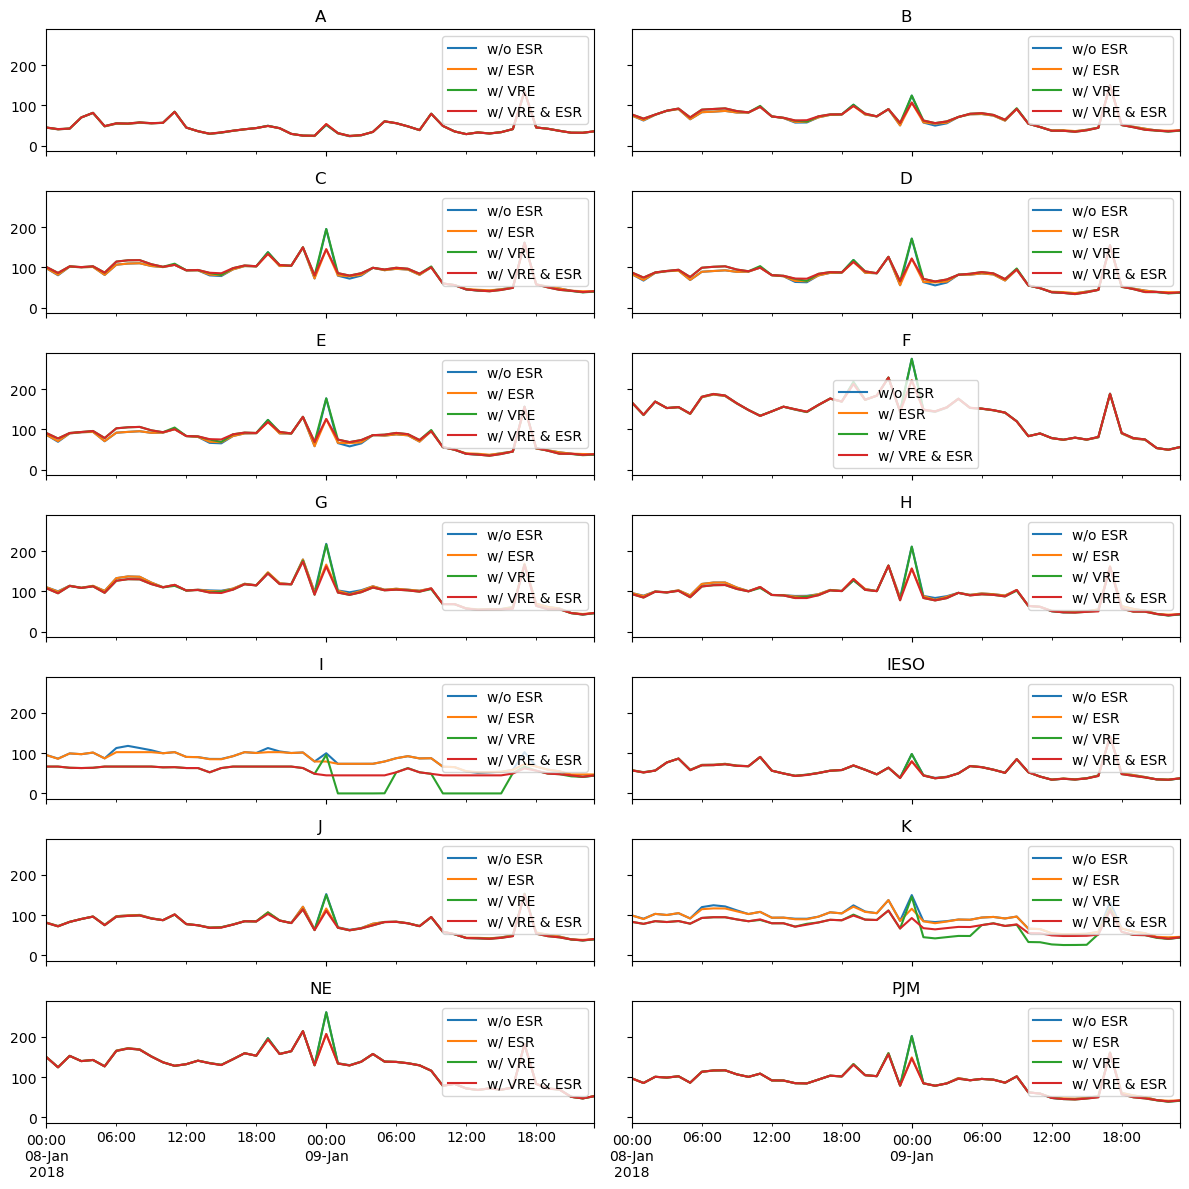

In [27]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    lmp_w_vre_zone.iloc[:, i].plot(ax=ax, label='w/ VRE')
    lmp_w_vre_esr_zone.iloc[:, i].plot(ax=ax, label='w/ VRE & ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()

fig.tight_layout()

<Axes: title={'center': 'Zonal Load'}, xlabel='TimeStamp'>

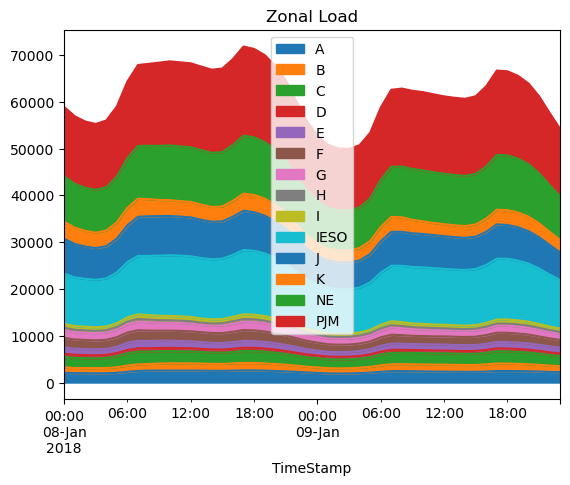

In [29]:
load_profile_elec.columns = bus_names
load_profile_zone = load_profile_elec.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

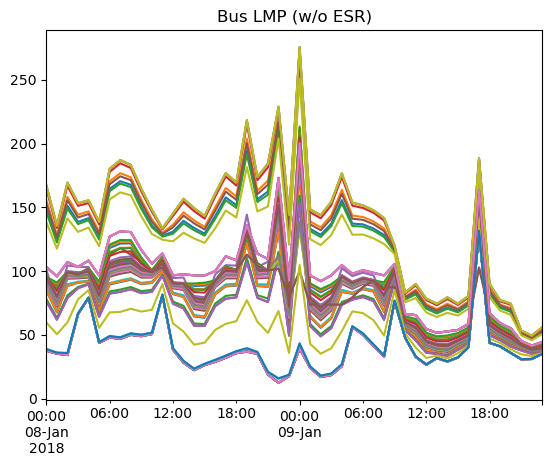

In [30]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

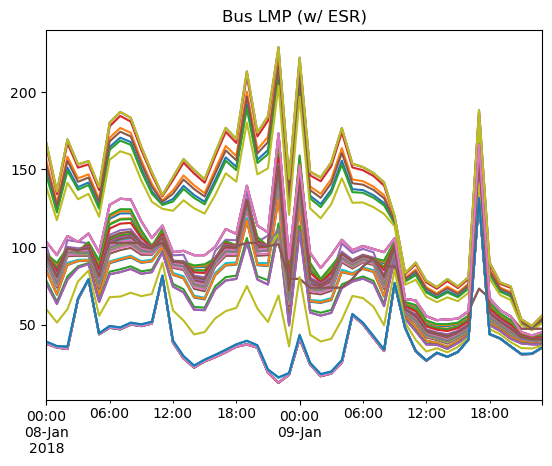

In [31]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

In [32]:
gen_max = genmax_profile[start_datetime:end_datetime]
gen_pg = results_0_wo_esr['PG'].iloc[:, :303]
gen_pg.columns = gen_max.columns
surplus = gen_max - gen_pg
surplus

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 00:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,-8.881784e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 01:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,-8.881784e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 02:00:00,17.1,18.5,18.5,0.0,0.1,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,3.552714e-15,0.0,0.0,8.881784e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 03:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,8.881784e-16,0.0,0.000000e+00,-3.552714e-15,0.000000e+00,0.0
2018-01-08 04:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,-3.552714e-15,-7.105427e-15,0.0
2018-01-08 05:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,8.881784e-16,0.0,0.000000e+00,0.000000e+00,7.105427e-15,0.0
2018-01-08 06:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,8.881784e-16,0.0,0.000000e+00,0.000000e+00,7.105427e-15,0.0
2018-01-08 07:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
2018-01-08 08:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,-3.552714e-15,0.000000e+00,0.0


### With initial conditions

In [33]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-09 00:00:00
End time: 2018-01-10 23:00:00


#### Without ESR

In [34]:
# Create NYGrid object
nygrid_sim_1_wo_esr = NYGrid(grid_data_dir,
                             start_datetime=start_datetime,
                             end_datetime=end_datetime,
                             dcline_prop=dcline_prop,
                             esr_prop=None,
                             verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile_elec)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpwa2ljhqc.pyomo.lp
Reading time = 0.27 seconds
x1: 80880 rows, 65521 columns, 404442 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80880 rows, 65521 columns and 404442 nonzeros
Model fingerprint: 0xe2a2c2c0
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 74668 rows and 49901 columns
Presolve time: 0.12s
Presolved: 6212 rows, 15620 columns, 61964 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.638e+04
 Factor NZ  : 2.127e+05 (rou

In [35]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 3522.2506434314964
s_if_max 8491.545664155205
s_if_min 280.12486047222296
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [36]:
# Create NYGrid object
nygrid_sim_1_w_esr = NYGrid(grid_data_dir,
                            start_datetime=start_datetime,
                            end_datetime=end_datetime,
                            dcline_prop=dcline_prop,
                            esr_prop=esr_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile_elec)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpmszt3ob3.pyomo.lp
Reading time = 0.29 seconds
x1: 95310 rows, 74161 columns, 434622 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 95310 rows, 74161 columns and 434622 nonzeros
Model fingerprint: 0x66de4897
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 87511 rows and 54136 columns
Presolve time: 0.14s
Presolved: 7799 rows, 20025 columns, 74602 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.398e+04
 Factor NZ  : 3.038e+05 (rou

In [37]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 7787.267677866262
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With VRE

In [38]:
# Create NYGrid object
nygrid_sim_1_w_vre = NYGrid(grid_data_dir,
                            start_datetime=start_datetime,
                            end_datetime=end_datetime,
                            dcline_prop=dcline_prop,
                            esr_prop=None,
                            vre_prop=vre_prop,
                            verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre.set_load_sch(load_profile_elec)
nygrid_sim_1_w_vre.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre.set_gen_init_data(gen_init=last_gen)

# Set options
# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre.solve_dc_opf()

# Get results
results_1_w_vre = nygrid_sim_1_w_vre.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp60zgv9nm.pyomo.lp
Reading time = 0.29 seconds
x1: 94320 rows, 75601 columns, 437902 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 94320 rows, 75601 columns and 437902 nonzeros
Model fingerprint: 0x148769a4
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 87794 rows and 58310 columns
Presolve time: 0.15s
Presolved: 6526 rows, 17291 columns, 70474 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.095e+04
 Factor NZ  : 2.147e+05 (rou

In [39]:
print("s_ramp_up", results_1_w_vre['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre['s_load_shed'].sum())
print("s_if_max", results_1_w_vre['s_if_max'].sum())
print("s_if_min", results_1_w_vre['s_if_min'].sum())
print("s_br_max", results_1_w_vre['s_br_max'].sum())
print("s_br_min", results_1_w_vre['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 8986.095426748261
s_if_min 2294.1341418287216
s_br_max 0.0
s_br_min 0.0


#### With VRE and ESR

In [40]:
# Create NYGrid object
nygrid_sim_1_w_vre_esr = NYGrid(grid_data_dir,
                                start_datetime=start_datetime,
                                end_datetime=end_datetime,
                                dcline_prop=dcline_prop,
                                esr_prop=esr_prop,
                                vre_prop=vre_prop,
                                verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_vre_esr.set_load_sch(load_profile_elec)
nygrid_sim_1_w_vre_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_vre_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_vre_esr.set_vre_max_sch(genmax_profile_vre)
nygrid_sim_1_w_vre_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_vre_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_vre_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_vre_esr.relax_external_branch_lim()

# Set generator initial condition
last_gen = results_0_w_vre_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_vre_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_vre_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_vre_esr.solve_dc_opf()

# Get results
results_1_w_vre_esr = nygrid_sim_1_w_vre_esr.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp5maldclg.pyomo.lp
Reading time = 0.32 seconds
x1: 108750 rows, 84241 columns, 468082 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 108750 rows, 84241 columns and 468082 nonzeros
Model fingerprint: 0x1602fe8e
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 100539 rows and 62462 columns
Presolve time: 0.16s
Presolved: 8211 rows, 21779 columns, 82518 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.953e+04
 Factor NZ  : 3.021e+05 (

In [41]:
print("s_ramp_up", results_1_w_vre_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_vre_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_vre_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_vre_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_vre_esr['s_if_max'].sum())
print("s_if_min", results_1_w_vre_esr['s_if_min'].sum())
print("s_br_max", results_1_w_vre_esr['s_br_max'].sum())
print("s_br_min", results_1_w_vre_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 5377.241641158234
s_if_min 941.9896978750565
s_br_max 0.0
s_br_min 0.0


## Process the results

In [42]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [43]:
# Format results
thermal_pg_0_wo_esr = (results_0_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_0_w_esr = (results_0_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_0_w_vre = (results_0_w_vre['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_0_w_vre_esr = (results_0_w_vre_esr['PG'].iloc[:, :num_thermal]
                          .rename(columns=gen_rename))

thermal_pg_1_wo_esr = (results_1_wo_esr['PG'].iloc[:, :num_thermal]
                       .rename(columns=gen_rename))

thermal_pg_1_w_esr = (results_1_w_esr['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_1_w_vre = (results_1_w_vre['PG'].iloc[:, :num_thermal]
                      .rename(columns=gen_rename))

thermal_pg_1_w_vre_esr = (results_1_w_vre_esr['PG'].iloc[:, :num_thermal]
                          .rename(columns=gen_rename))

NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object

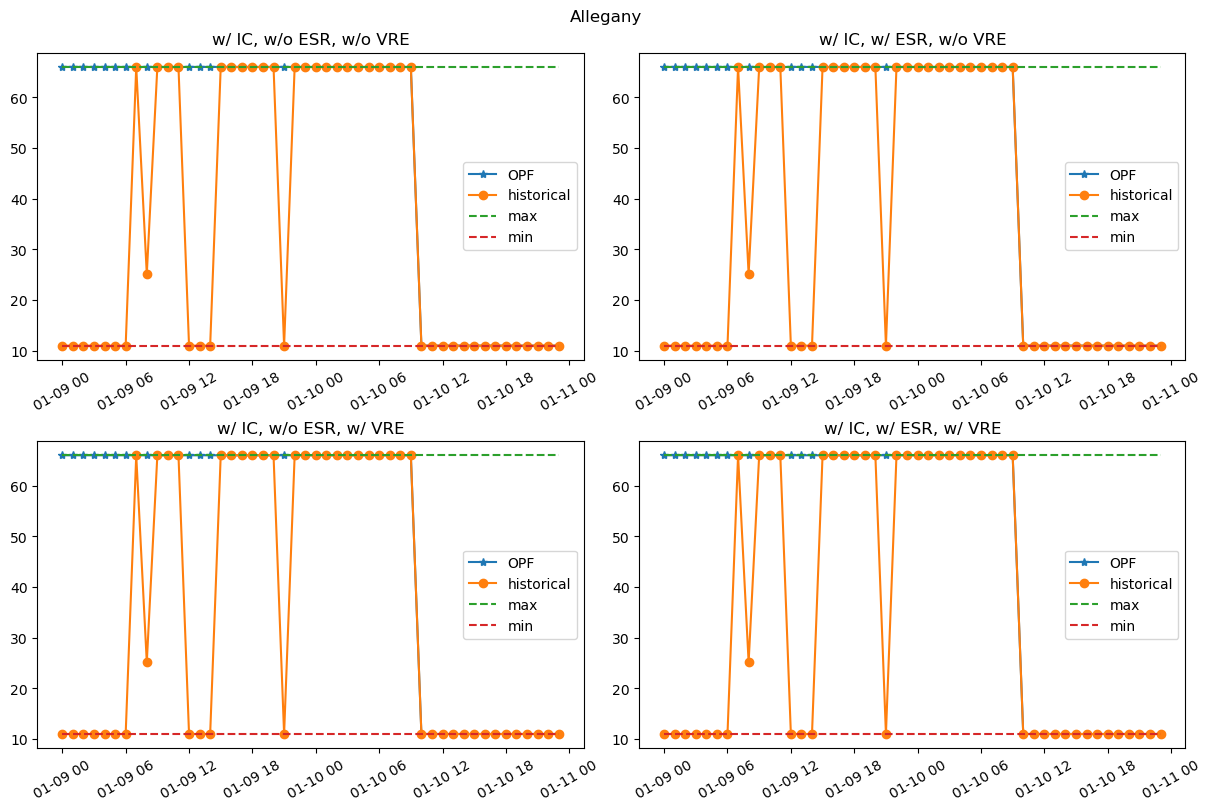

In [44]:
ii = 3
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/ IC, w/o ESR, w/o VRE")
axs[0, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/ IC, w/ ESR, w/o VRE")
axs[1, 0] = plot_gen(thermal_pg_1_w_vre.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR, w/ VRE")
axs[1, 1] = plot_gen(thermal_pg_1_w_vre_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR, w/ VRE")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object

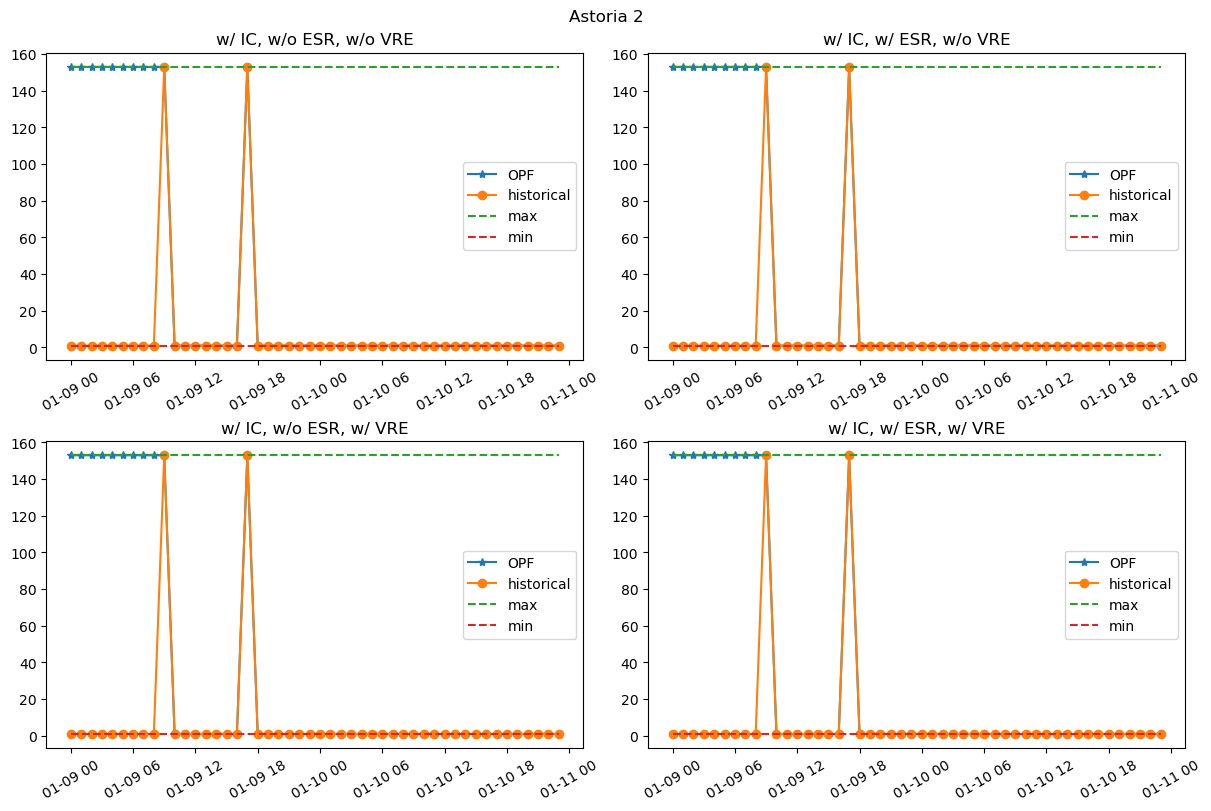

In [45]:
ii = 9
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/ IC, w/o ESR, w/o VRE")
axs[0, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/ IC, w/ ESR, w/o VRE")
axs[1, 0] = plot_gen(thermal_pg_1_w_vre.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR, w/ VRE")
axs[1, 1] = plot_gen(thermal_pg_1_w_vre_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR, w/ VRE")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()

NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object

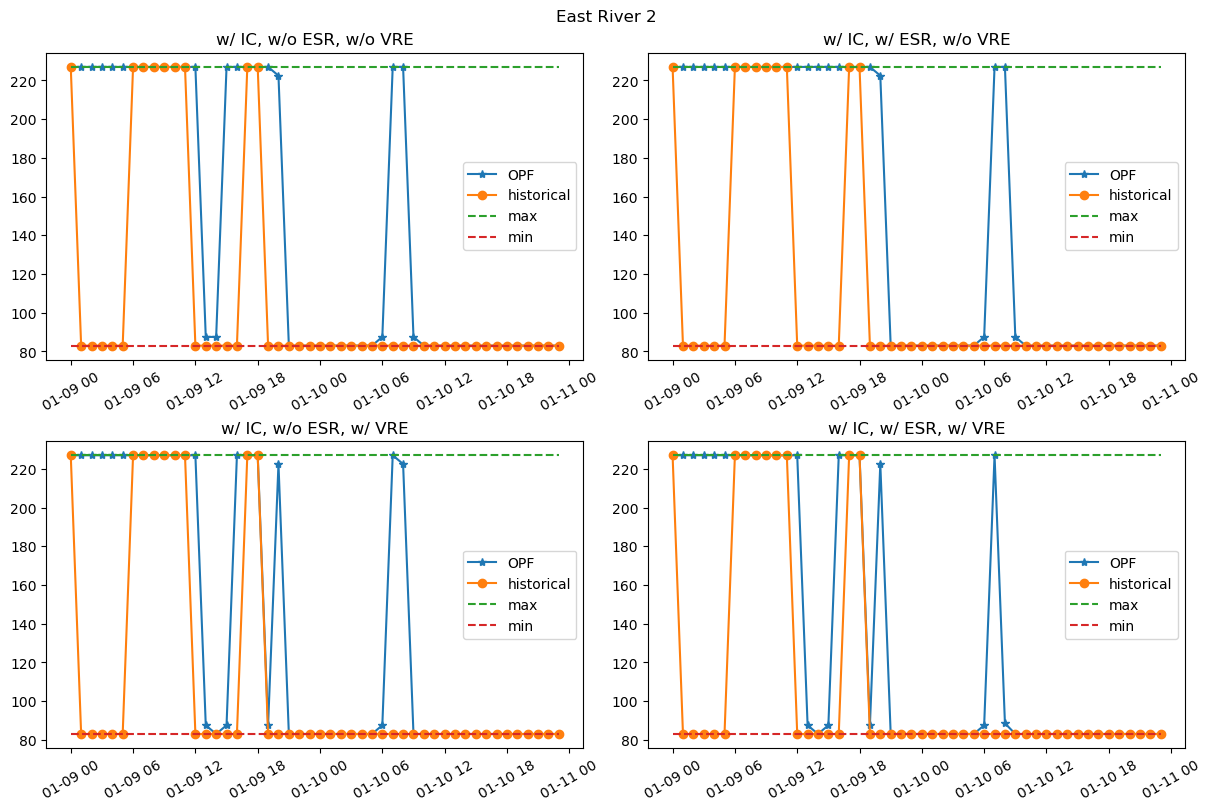

In [46]:
ii = 83
display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')

axs[0, 0] = plot_gen(thermal_pg_1_wo_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 0], title="w/ IC, w/o ESR, w/o VRE")
axs[0, 1] = plot_gen(thermal_pg_1_w_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[0, 1], title="w/ IC, w/ ESR, w/o VRE")
axs[1, 0] = plot_gen(thermal_pg_1_w_vre.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 0], title="w/ IC, w/o ESR, w/ VRE")
axs[1, 1] = plot_gen(thermal_pg_1_w_vre_esr.iloc[:, ii],
                     gen_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmax_profile[start_datetime:end_datetime].iloc[:, ii],
                     genmin_profile[start_datetime:end_datetime].iloc[:, ii],
                     ax=axs[1, 1], title="w/ IC, w/ ESR, w/ VRE")
for ax in axs.flat:
    ax.tick_params(axis='x', rotation=30)
fig.suptitle(f'{gen_info.NYISOName[ii]}')
fig.show()